In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Results already exist
PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
(435, 91)


/home/musa/protein-dihedral-visualization/lib/plotting.py:276: RuntimeWarning: Mean of empty slice
  X = np.where(np.isnan(X), np.nanmean(X,axis=0), X)


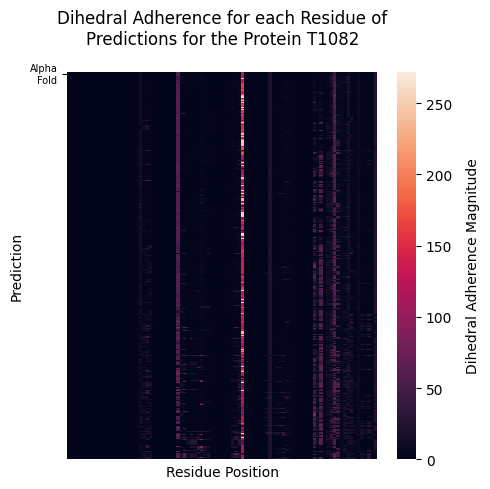

In [51]:
WINDOW_SIZE = 5
WINDOW_SIZE_CONTEXT = 6
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'
casp_protein_id = 'T1082'   # 6ya2
da = DihedralAdherence(casp_protein_id, WINDOW_SIZE, WINDOW_SIZE_CONTEXT, PDBMINE_URL, PROJECT_DIR)
# da.check_alignment()
# da.compute_structures()
# da.query_pdbmine()\
# da.load_results()
# da.compute_mds(skip_existing=False)
da.load_results_md()
# da.plot_heatmap(fillna=False)
# da.plot_md_for_seq()
# both = da.plot_res_vs_md(pred_id=da.alphafold_id)
both = da.plot_heatmap()
# da.plot_md_vs_rmsd()

In [12]:
targetlist = pd.read_csv('targetlist.csv', sep=';')
for target in targetlist.Target.unique():
    try:
        da = DihedralAdherence(target, WINDOW_SIZE, WINDOW_SIZE_CONTEXT, PDBMINE_URL, PROJECT_DIR)
    except ValueError as e:
        print(f'Skipping {target}: {e}')
    da.compute_structures()
    da.query_pdbmine()
    da.compute_mds()

Results already exist
PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Results already exist
PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
PDB: 6s44


--2024-05-22 21:34:48--  https://predictioncenter.org/download_area/CASP14/predictions/regular/T1026.tar.gz
Resolving predictioncenter.org (predictioncenter.org)... 128.120.136.155
Connecting to predictioncenter.org (predictioncenter.org)|128.120.136.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12268251 (12M) [application/x-gzip]
Saving to: ‘casp-predictions/T1026.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  259K 46s
    50K .......... .......... .......... .......... ..........  0%  531K 34s
   100K .......... .......... .......... .......... ..........  1% 6.44M 23s
   150K .......... .......... .......... .......... ..........  1%  577K 22s
   200K .......... .......... .......... .......... ..........  2% 6.39M 18s
   250K .......... .......... .......... .......... ..........  2% 6.40M 15s
   300K .......... .......... .......... .......... ..........  2%  188K 22s
   350K .......... .......... .......... .......... 

T1026/
T1026/T1026TS460_2
T1026/T1026TS343_1
T1026/T1026TS042_4
T1026/T1026TS070_4
T1026/T1026TS052_2
T1026/T1026TS367_2
T1026/T1026TS458_4
T1026/T1026TS277_1
T1026/T1026TS129_5
T1026/T1026TS323_5
T1026/T1026TS140_5
T1026/T1026TS071_2
T1026/T1026TS027_1
T1026/T1026TS257_2
T1026/T1026TS183_3
T1026/T1026TS349_2
T1026/T1026TS031_4
T1026/T1026TS293_4
T1026/T1026TS198_2
T1026/T1026TS364_3
T1026/T1026TS039_3
T1026/T1026TS428_2
T1026/T1026TS378_3
T1026/T1026TS054_1
T1026/T1026TS392_5
T1026/T1026TS480_1
T1026/T1026TS198_4
T1026/T1026TS326_3
T1026/T1026TS217_2
T1026/T1026TS032_4
T1026/T1026TS101_4
T1026/T1026TS341_2
T1026/T1026TS420_5
T1026/T1026TS005_1
T1026/T1026TS009_1
T1026/T1026TS063_3
T1026/T1026TS170_2
T1026/T1026TS317_1
T1026/T1026TS183_1
T1026/T1026TS097_5
T1026/T1026TS050_1
T1026/T1026TS349_4
T1026/T1026TS377_3
T1026/T1026TS050_4
T1026/T1026TS070_5
T1026/T1026TS376_2
T1026/T1026TS042_2
T1026/T1026TS376_3
T1026/T1026TS335_1
T1026/T1026TS140_1
T1026/T1026TS376_1
T1026/T1026TS377_2
T1026

--2024-05-22 21:34:55--  https://predictioncenter.org/download_area/CASP14/predictions/regular/T1029.tar.gz
Resolving predictioncenter.org (predictioncenter.org)... 128.120.136.155
Connecting to predictioncenter.org (predictioncenter.org)|128.120.136.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9437618 (9.0M) [application/x-gzip]
Saving to: ‘casp-predictions/T1029.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  260K 35s
    50K .......... .......... .......... .......... ..........  1%  529K 26s
   100K .......... .......... .......... .......... ..........  1% 6.77M 18s
   150K .......... .......... .......... .......... ..........  2%  576K 17s
   200K .......... .......... .......... .......... ..........  2% 6.52M 14s
   250K .......... .......... .......... .......... ..........  3% 6.37M 12s
   300K .......... .......... .......... .......... ..........  3%  234K 15s
   350K .......... .......... .......... .......... 

T1029/
T1029/T1029TS042_4
T1029/T1029TS326_2
T1029/T1029TS323_4
T1029/T1029TS326_3
T1029/T1029TS334_1
T1029/T1029TS304_5
T1029/T1029TS487_4
T1029/T1029TS349_5
T1029/T1029TS352_5
T1029/T1029TS052_4
T1029/T1029TS392_5
T1029/T1029TS032_3
T1029/T1029TS326_4
T1029/T1029TS301_1
T1029/T1029TS319_3
T1029/T1029TS387_1
T1029/T1029TS364_2
T1029/T1029TS031_2
T1029/T1029TS015_3
T1029/T1029TS026_1
T1029/T1029TS498_5
T1029/T1029TS278_4
T1029/T1029TS334_2
T1029/T1029TS032_2
T1029/T1029TS337_1
T1029/T1029TS024_5
T1029/T1029TS070_4
T1029/T1029TS039_3
T1029/T1029TS375_1
T1029/T1029TS042_3
T1029/T1029TS081_4
T1029/T1029TS131_4
T1029/T1029TS376_5
T1029/T1029TS435_3
T1029/T1029TS293_5
T1029/T1029TS226_2
T1029/T1029TS018_4
T1029/T1029TS060_3
T1029/T1029TS063_2
T1029/T1029TS334_5
T1029/T1029TS015_4
T1029/T1029TS062_4
T1029/T1029TS328_2
T1029/T1029TS458_1
T1029/T1029TS349_2
T1029/T1029TS015_1
T1029/T1029TS131_1
T1029/T1029TS209_1
T1029/T1029TS067_2
T1029/T1029TS368_4
T1029/T1029TS335_5
T1029/T1029TS314_5
T1029

--2024-05-22 21:35:00--  https://predictioncenter.org/download_area/CASP14/predictions/regular/T1033.tar.gz
Resolving predictioncenter.org (predictioncenter.org)... 128.120.136.155
Connecting to predictioncenter.org (predictioncenter.org)|128.120.136.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7642014 (7.3M) [application/x-gzip]
Saving to: ‘casp-predictions/T1033.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  260K 29s
    50K .......... .......... .......... .......... ..........  1%  528K 21s
   100K .......... .......... .......... .......... ..........  2% 6.79M 14s
   150K .......... .......... .......... .......... ..........  2%  573K 14s
   200K .......... .......... .......... .......... ..........  3% 6.71M 11s
   250K .......... .......... .......... .......... ..........  4% 6.48M 9s
   300K .......... .......... .......... .......... ..........  4%  233K 12s
   350K .......... .......... .......... .......... .

T1033/
T1033/T1033TS220_3
T1033/T1033TS138_2
T1033/T1033TS324_4
T1033/T1033TS063_4
T1033/T1033TS324_3
T1033/T1033TS437_5
T1033/T1033TS024_5
T1033/T1033TS460_2
T1033/T1033TS238_1
T1033/T1033TS060_2
T1033/T1033TS226_3
T1033/T1033TS140_5
T1033/T1033TS003_1
T1033/T1033TS217_5
T1033/T1033TS226_5
T1033/T1033TS170_5
T1033/T1033TS420_3
T1033/T1033TS031_2
T1033/T1033TS488_3
T1033/T1033TS293_1
T1033/T1033TS198_2
T1033/T1033TS403_1
T1033/T1033TS335_2
T1033/T1033TS334_5
T1033/T1033TS364_3
T1033/T1033TS192_5
T1033/T1033TS107_1
T1033/T1033TS067_2
T1033/T1033TS042_1
T1033/T1033TS062_4
T1033/T1033TS304_5
T1033/T1033TS131_1
T1033/T1033TS288_1
T1033/T1033TS070_2
T1033/T1033TS063_1
T1033/T1033TS392_1
T1033/T1033TS039_2
T1033/T1033TS343_2
T1033/T1033TS259_2
T1033/T1033TS488_2
T1033/T1033TS392_2
T1033/T1033TS024_3
T1033/T1033TS293_3
T1033/T1033TS097_2
T1033/T1033TS362_1
T1033/T1033TS351_3
T1033/T1033TS032_1
T1033/T1033TS193_1
T1033/T1033TS319_2
T1033/T1033TS070_4
T1033/T1033TS472_5
T1033/T1033TS339_4
T1033

--2024-05-22 21:35:05--  https://predictioncenter.org/download_area/CASP14/predictions/regular/T1034.tar.gz
Resolving predictioncenter.org (predictioncenter.org)... 128.120.136.155
Connecting to predictioncenter.org (predictioncenter.org)|128.120.136.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12335995 (12M) [application/x-gzip]
Saving to: ‘casp-predictions/T1034.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  259K 46s
    50K .......... .......... .......... .......... ..........  0%  530K 34s
   100K .......... .......... .......... .......... ..........  1% 6.74M 23s
   150K .......... .......... .......... .......... ..........  1%  573K 23s
   200K .......... .......... .......... .......... ..........  2% 6.42M 18s
   250K .......... .......... .......... .......... ..........  2% 6.68M 16s
   300K .......... .......... .......... .......... ..........  2%  181K 22s
   350K .......... .......... .......... .......... 

T1034/
T1034/T1034TS278_1
T1034/T1034TS379_4
T1034/T1034TS096_1
T1034/T1034TS324_1
T1034/T1034TS187_4
T1034/T1034TS211_2
T1034/T1034TS033_2
T1034/T1034TS066_3
T1034/T1034TS131_5
T1034/T1034TS015_4
T1034/T1034TS420_2
T1034/T1034TS066_5
T1034/T1034TS009_5
T1034/T1034TS253_2
T1034/T1034TS013_2
T1034/T1034TS198_3
T1034/T1034TS217_1
T1034/T1034TS314_3
T1034/T1034TS209_3
T1034/T1034TS253_3
T1034/T1034TS151_3
T1034/T1034TS293_2
T1034/T1034TS293_1
T1034/T1034TS480_1
T1034/T1034TS409_1
T1034/T1034TS298_3
T1034/T1034TS342_3
T1034/T1034TS101_2
T1034/T1034TS278_4
T1034/T1034TS173_1
T1034/T1034TS343_3
T1034/T1034TS349_3
T1034/T1034TS328_1
T1034/T1034TS427_2
T1034/T1034TS005_2
T1034/T1034TS360_1
T1034/T1034TS125_5
T1034/T1034TS277_3
T1034/T1034TS326_3
T1034/T1034TS343_5
T1034/T1034TS200_3
T1034/T1034TS029_5
T1034/T1034TS039_5
T1034/T1034TS342_2
T1034/T1034TS129_3
T1034/T1034TS050_3
T1034/T1034TS403_2
T1034/T1034TS067_4
T1034/T1034TS183_1
T1034/T1034TS026_5
T1034/T1034TS476_1
T1034/T1034TS373_1
T1034

FileNotFoundError: [Errno 2] No such file or directory: 'casp-results/H1036-D1.txt'

Results already exist
PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Results already exist
PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
Results already exist
PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 
Results already exist
PDB: 7cn6
Structure exists: 'pdb/pdb7cn6.ent' 
Results already exist
PDB: 7w6b
Structure exists: 'pdb/pdb7w6b.ent' 
Results already exist
PDB: 7abw
Structure exists: 'pdb/pdb7abw.ent' 
Results already exist
PDB: 6y4f
Structure exists: 'pdb/pdb6y4f.ent' 
Results already exist
PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
Results already exist
PDB: 6yj1
Structure exists: 'pdb/pdb6yj1.ent' 
Results already exist
PDB: 6ya2
Structure exists: 'pdb/pdb6ya2.ent' 
Results already exist
PDB: 6uv6
Structure exists: 'pdb/pdb6uv6.ent' 
Results already exist
PDB: 6vqp
Structure exists: 'pdb/pdb6vqp.ent' 
Model R-squared: 0.852087, Adj R-squared: 0.822163, p-value: 0.0


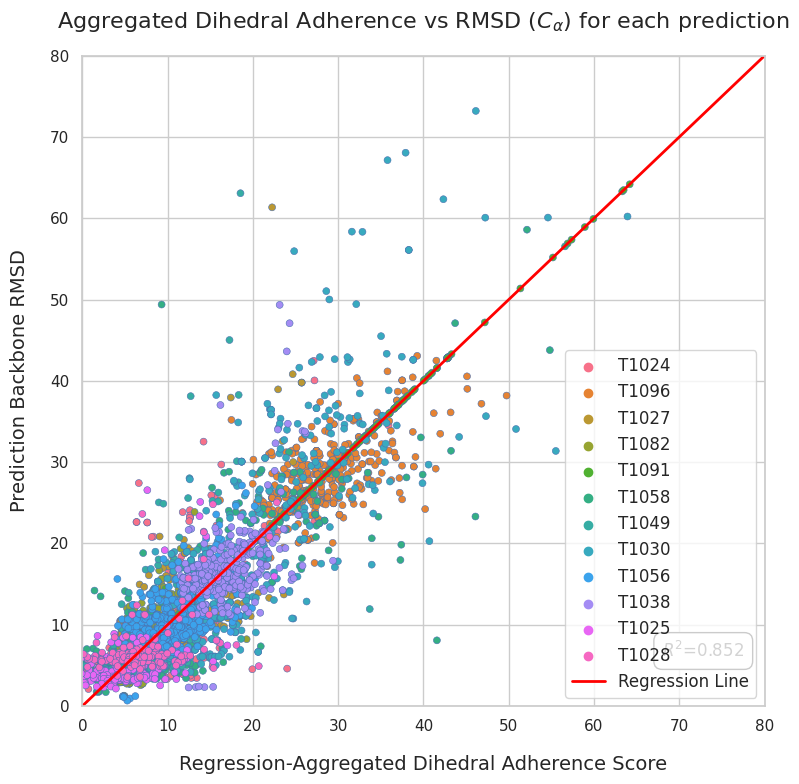

In [71]:
from lib import fit_model_on_multiple
WINDOW_SIZE = 5
WINDOW_SIZE_CONTEXT = 6
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'

# model, grouped_preds = fit_model_on_multiple(['T1056', 'T1038', 'T1025', 'T1028'], WINDOW_SIZE, WINDOW_SIZE_CONTEXT, PDBMINE_URL, n_comp=2000)
model, grouped_preds = fit_model_on_multiple(
    ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028'], 
    WINDOW_SIZE, WINDOW_SIZE_CONTEXT, PDBMINE_URL, PROJECT_DIR,
    n_comp=2000,
    axlims=((0,80),(0,80))
)